<a href="https://colab.research.google.com/github/kaisardauletbek/Learning-NLP/blob/main/NewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')


Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 1.7MB 25.8MB/s 
     |████████████████████████████████| 24.2MB 1.5MB/s 
     |████████████████████████████████| 307kB 44.1MB/s 
     |████████████████████████████████| 8.2MB 45.4MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=43b9a668f90085fb1da365172273fb20da2ee7c6c50bac34f4e573153dcc2645
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626604 sha256=4ac32593653d5c9a2697d

In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()
torch.cuda.is_available()

True

In [5]:
train_source = fetch_20newsgroups(subset = 'train')
test_source = fetch_20newsgroups(subset = 'test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [6]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))


from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [7]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


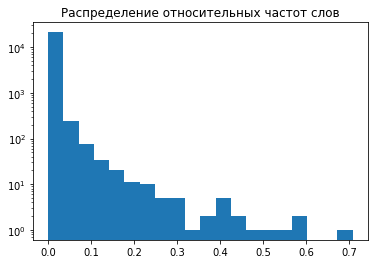

In [8]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [9]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


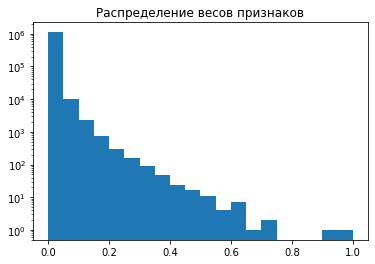

In [10]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### **Class Distribution**

In [11]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


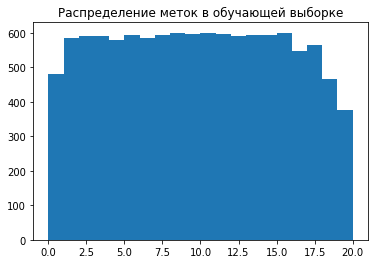

In [12]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

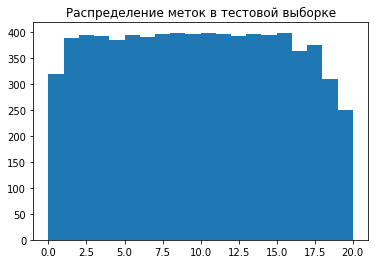

In [13]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

In [14]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [15]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 1.97 сек
Среднее значение функции потерь на обучении 2.2250264758444103
Среднее значение функции потерь на валидации 2.119316889067828
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.79 сек
Среднее значение функции потерь на обучении 0.916481945474269
Среднее значение функции потерь на валидации 1.675762368965957
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 1.78 сек
Среднее значение функции потерь на обучении 0.46593014845403574
Среднее значение функции потерь на валидации 1.473660517041966
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 1.80 сек
Среднее значение функции потерь на обучении 0.2840377256947722
Среднее значение функции потерь на валидации 1.3451712123923383
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 1.78 сек
Среднее значение функции потерь на обучении 0.1906785826267159
Среднее значение функции потерь на валидации 1.2647121106669055
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 1.78 сек
Среднее значение функции потер

In [19]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:01<00:00, 210.50it/s]
 10%|▉         | 23/235.375 [00:00<00:00, 226.33it/s]

Среднее значение функции потерь на обучении 0.003156969090923667
Доля верных ответов 0.9993812975075128



236it [00:01, 210.91it/s]                             


Среднее значение функции потерь на валидации 0.9307188391685486
Доля верных ответов 0.7651354221986192


### Now Checking With SciKitLearn

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

In [26]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.9463521135647475
Доля верных ответов 0.7389075481704084

Среднее значение функции потерь на валидации 2.981962939747759
Доля верных ответов 0.34930961232076474


In [24]:
#MAX_DF = 1
#MIN_COUNT = 0

import re

token = 'Казнить нельзя, помиловать. Нельзя наказывать. Казнить, нельзя помиловать. Нельзя освободить. Нельзя не помиловать. Обязательно освободить.'
# модифицируйте это регулярное выражение
TOKENIZE_RE = re.compile(r'[\w\d]+', re.I)


def tokenize(txt):
    return TOKENIZE_RE.findall(txt)

token1 = tokenize(token)
print(token1)
for i in range(len(token1)):
  token1[i] = token1[i].lower()
token1 = [token1]
print(token1)
words, counts = build_vocabulary(token1)
word_df = [(word, counts[i]) for i, (word, counts) in enumerate(words.items())]
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items()))

['Казнить', 'нельзя', 'помиловать', 'Нельзя', 'наказывать', 'Казнить', 'нельзя', 'помиловать', 'Нельзя', 'освободить', 'Нельзя', 'не', 'помиловать', 'Обязательно', 'освободить']
[['казнить', 'нельзя', 'помиловать', 'нельзя', 'наказывать', 'казнить', 'нельзя', 'помиловать', 'нельзя', 'освободить', 'нельзя', 'не', 'помиловать', 'обязательно', 'освободить']]
Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9), ('what', 10), ('they', 11), ('university', 12), ('would', 13), ('about', 14), ('will', 15), ('like', 16), ('some', 17), ('just', 18), ('your', 19), ('know', 20), ('more', 21), ('when', 22), ('which', 23), ('only', 24), ('other', 25), ('think', 26), ('than', 27), ('does', 28), ('distribution', 29), ('also', 30), ('them', 31), ('been', 32), ('people', 33), ('their', 34), ('time', 35), ('were', 36), ('could', 37), ('good', 38), ('then', 39), ('reply', 40), ('well',

In [17]:
corpus = [
    'Казнить нельзя, помиловать. Нельзя наказывать.',
    'Казнить, нельзя помиловать. Нельзя освободить.',
    'Нельзя не помиловать.',
    'Обязательно освободить.']

## Получение df
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(smooth_idf=False, use_idf=True)
vectorizer.fit_transform(corpus)
word_doc_freq = 1/np.exp(vectorizer.idf_ - 1) ## ВОТ ОСОБЕННОСТЬ ПЕРЕВОДА ИЗ IDF В DF
vectorizer.get_feature_names()

['казнить',
 'наказывать',
 'не',
 'нельзя',
 'обязательно',
 'освободить',
 'помиловать']

In [18]:
from collections import Counter
import pandas as pd
import re

corpus = ['Казнить нельзя, помиловать. Нельзя наказывать.',
         'Казнить, нельзя помиловать. Нельзя освободить.',
         'Нельзя не помиловать.',
         'Обязательно освободить.']
TOKENIZE_RE = re.compile(r'[\w\d]+')

corpus = pd.Series(corpus).str.lower().apply(TOKENIZE_RE.findall)
corpus_counts = corpus.apply(Counter).apply(pd.Series).fillna(0).astype(int)
word2freq = (corpus_counts > 0).mean(0).sort_index().sort_values()

### ^ код из 5 шага

import numpy as np

TF = (corpus_counts[word2freq.index].T / corpus.apply(len)).T
lTFIDF = np.log(TF + 1) / word2freq
feature_matrix  = (lTFIDF - lTFIDF.mean()) / lTFIDF.std(0, ddof=1)

for doc in feature_matrix.round(2).values:
    print(*doc)

1.5 -0.5 -0.5 0.87 -0.76 0.6 0.16
-0.5 -0.5 -0.5 0.87 0.18 0.6 0.16
-0.5 1.5 -0.5 -0.87 -0.76 0.29 1.04
-0.5 -0.5 1.5 -0.87 1.34 -1.48 -1.36
